# MOM6 ANALYSIS - Eddy Shedding
**Here I'm trying to clean up the notebook as it's getting a little messy**
Here I'm starting the investigation of Eddy Shedding within the EAC Separation region. This is in an effort to present at the PO meeting next week, however I wanted to leave the model evaluation presentation to a future COSIMA meeting rather than the PO Meeting. 

In this notebook I aim to look at the eddy kinetic energy (EKE) in the separation region, and how this might relate to changes in mean kinetic energy (MKE) further north, as well as available potential energy (APE) further north as well. I'd like to look at ways to approximate the eddy energy conversion terms (i.e., barotropic/baroclinic instability pathways) and also consider filtering the data to extract the mesoscale frequencies of interest. 

### 1. Load in data and subset in space around the EAC Separation site

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf

In [2]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [3]:
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature


In [5]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33003/status,
Dashboard: /proxy/33003/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34121,Workers: 14
Dashboard: /proxy/33003/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:36945,Total threads: 1
Dashboard: /proxy/34047/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38941,


In [6]:
# set paths to model output
## SRM
# eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003-latest/'
eac_003 = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6-setonix/sthpac_iaf_01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'
## EAC MOORING 
eac_mooring = '/scratch/v45/jr5971/eac-mooring/'

In [7]:
# import os
# os.chdir('/home/581/jr5971/jr5971/notebooks/')
# # from custom_funcs import *
from myfuncs import *

## Contents

### 1. ACCESS-OM2 EKE calcs

In [8]:
# Select u,v and subset to same domain as 'eac_eddy' 
eddy_idx = {'W':-210, 'E':-204, 'S':-40, 'N':-24}

**Open the velocity components from access**

In [9]:
u = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/u_om2_z30_eac.nc')
v = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/v_om2_z30_eac.nc')
u

<xarray.DataArray 'u' (time: 10957, yu_ocean: 190, xu_ocean: 60)>
[124909800 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

In [10]:
%%time
# Calculate mean velocities across the eddy box
v_om2_mean = v.mean('time')#.compute()
u_om2_mean = u.mean('time')#.compute()
# Calculate transient velocities
v_om2_transient = v - v_om2_mean
u_om2_transient = u - u_om2_mean

CPU times: user 7.77 s, sys: 1.77 s, total: 9.54 s
Wall time: 9.25 s


In [11]:
# Calculate EKE
EKE_om2 = (0.5 * (u_om2_transient**2 + v_om2_transient**2))#.compute()
EKE_om2

<xarray.DataArray (time: 10957, yu_ocean: 190, xu_ocean: 60)>
array([[[1.07357102e-02, 1.01166200e-02, 9.30453651e-03, ...,
         1.37928296e-02, 1.78901926e-02, 1.86305419e-02],
        [1.03588914e-02, 9.63680167e-03, 8.56501702e-03, ...,
         1.47418510e-02, 1.71798542e-02, 1.71113200e-02],
        [9.56978183e-03, 9.06575844e-03, 7.88485073e-03, ...,
         1.51828052e-02, 1.74985956e-02, 1.75634846e-02],
        ...,
        [           nan,            nan,            nan, ...,
         1.30505323e-05, 9.33804695e-05, 2.42249022e-04],
        [           nan,            nan,            nan, ...,
         3.96744115e-04, 3.55897268e-04, 5.85332164e-04],
        [           nan,            nan,            nan, ...,
         9.33399017e-04, 4.19537188e-04, 1.39373518e-03]],

       [[1.47799496e-02, 1.46280695e-02, 1.35908779e-02, ...,
         6.38618087e-03, 6.62772032e-03, 6.10647444e-03],
        [1.32254753e-02, 1.31477164e-02, 1.23698553e-02, ...,
         7.40314927e-03, 8.17153044e-03, 8.35848041e-03],
        [1.17704272e-02, 1.18223466e-02, 1.11552663e-02, ...,
         9.16144252e-03, 1.06257759e-02, 1.13214888e-02],
...
        [           nan,            nan,            nan, ...,
         8.90704617e-03, 1.91983543e-02, 3.43676694e-02],
        [           nan,            nan,            nan, ...,
         4.60954290e-03, 1.43279703e-02, 2.88370978e-02],
        [           nan,            nan,            nan, ...,
         1.86811027e-03, 1.08409422e-02, 2.35278420e-02]],

       [[9.59638692e-03, 1.96150094e-02, 3.39791253e-02, ...,
         2.36135256e-02, 1.91198010e-02, 1.56867802e-02],
        [9.13627446e-03, 2.04035044e-02, 3.43184508e-02, ...,
         6.84543652e-03, 5.28066605e-03, 6.21922594e-03],
        [2.24146470e-02, 3.47842127e-02, 4.82508764e-02, ...,
         7.34085042e-04, 1.53757317e-03, 4.53768903e-03],
        ...,
        [           nan,            nan,            nan, ...,
         9.55959596e-03, 2.23126300e-02, 4.02230136e-02],
        [           nan,            nan,            nan, ...,
         4.52561118e-03, 1.51695553e-02, 3.16886380e-02],
        [           nan,            nan,            nan, ...,
         1.18671567e-03, 9.94806737e-03, 2.42159721e-02]]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
    st_ocean  float64 29.45
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00

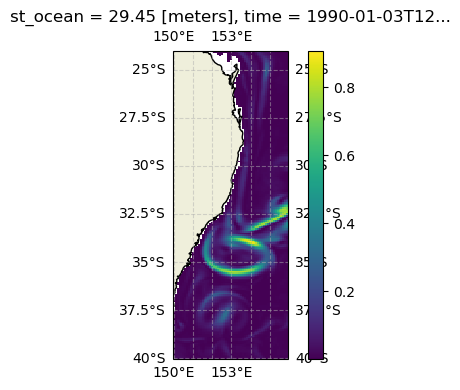

In [12]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))

EKE_om2.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')


**Plot an interactive map of EKE**

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [14]:
def plot_eac_eke(i):
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [15]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

### Vorticity Calculation

In [16]:
# Parameters used for computing quantities
Omega = 7.292e-5 # Earth's rotation rate in radian/s
Rearth = 6371.e3 # Earth's radius in m

In [17]:
lon = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output000/ocean/ocean-2d-geolon_c.nc')['geolon_c']
lat = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output000/ocean/ocean-2d-geolat_c.nc')['geolat_c']
lon

<xarray.DataArray 'geolon_c' (yu_ocean: 2700, xu_ocean: 3600)>
[9720000 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:     uv longitude
    units:         degrees_E
    valid_range:   [-281.  361.]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c

In [18]:
# Calculate the Coriolis parameter f = 2*Omega*sin(lat)
f = 2 * Omega * np.sin(np.deg2rad(lat))
f.attrs['long_name'] = 'Coriolis Parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

In [19]:
## Get grid information from old experiment
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid_old = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')
grid_old.data_vars

Data variables:
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    drag_coeff

In [20]:
# Get the grid variables from the most recent OM2 experiment
## create list of variable names from older grid
grid_vars=list(grid_old.data_vars)
## Create empty list to store variable pathnames
grid_file_ls = []
## Loop through grid-variable names, find path, and append to empty list
for var in grid_vars:
    pattern = f'{access}/output150/ocean/*{var}*.nc'
    matches = glob.glob(pattern)
    grid_file_ls.extend(matches)
# Open an xr.Dataset with all grid variables
grid = xr.open_mfdataset(grid_file_ls)
# Cut down to eddy box
grid = grid.sel(xt_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                xu_ocean=slice(eddy_idx['W'], eddy_idx['E']),
                yt_ocean=slice(eddy_idx['S'], eddy_idx['N']),
                yu_ocean=slice(eddy_idx['S'], eddy_idx['N']))

grid

<xarray.Dataset>
Dimensions:     (xt_ocean: 60, yt_ocean: 190, time: 2, xu_ocean: 60,
                 yu_ocean: 190)
Coordinates:
  * xt_ocean    (xt_ocean) float64 -209.9 -209.8 -209.7 ... -204.2 -204.1 -204.0
  * yt_ocean    (yt_ocean) float64 -39.95 -39.88 -39.8 ... -24.2 -24.11 -24.01
  * time        (time) datetime64[ns] 1900-01-01 1995-10-01
  * xu_ocean    (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean    (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
Data variables:
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(2, 190, 60), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-area_t.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221028T0304Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [21]:
# Create new dataset that has both velocity components and grid information
ds = xr.merge([u, v, grid])
# Update coordinate attributes
ds.coords['xt_ocean'].attrs.update(axis='X')
# Shift the corner (u) point 0.5 to the right of t-cell axis
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = Grid(ds, periodic=False)

Then, `xgcm` gives you a way to interpolate between grids (with the `.interp` function) and a way to compute differences (`.diff` function). For example, the expression $v(i,j,k) - v(i-1,j,k)$ is obtained via `grid.diff(ds.v, 'X')`.

Using `xgcm`'s functionality we can replicate the MOM5 vertical vorticity computation as:

In [22]:
%%time
zeta_xgcm = ( grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
             - grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

CPU times: user 829 ms, sys: 452 ms, total: 1.28 s
Wall time: 1.11 s


In [23]:
%%time
zeta_xgcm = zeta_xgcm.compute()

CPU times: user 4.67 s, sys: 3.08 s, total: 7.75 s
Wall time: 23.8 s


### Plotting

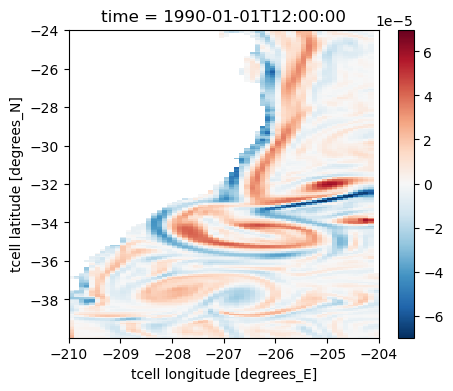

In [24]:
plt.figure(figsize=(5,4))
zeta_xgcm.isel(time=1).plot()

Okay, so this is pretty cool what I'm seeing above. The relative vorticity adds some value in terms of understanding the rotational shear in the current. 

In [25]:
maxvalue = 8e-5
def plot_eac_eke(i):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    
    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    zeta.isel(time=i).plot.contour(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [26]:
zeta = zeta_xgcm[1:,:,:]

In [27]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

What I'd like to do now is - have a third plot of temperature shading and streamlines for the velocity...

### Temperature and velocity streamlines

In [28]:
%%time
om2_temp = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/temp_om2_z30.nc')

CPU times: user 22.5 ms, sys: 7.74 ms, total: 30.2 ms
Wall time: 70.8 ms


#### Prepare data for streamplot
Here, it should be a lot easier to prepare the velocity data for ACCESS on the B-Grid compared to MOM6 on the C-grid. 

In [29]:
# define resolution of new target grid
res = 1 # 2 equals half the resolution of native grid
# Rename coords to lon/lat
u = u.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})
v = v.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})

# Create target grid with equal spaced points
x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
X_target, Y_target = np.meshgrid(x_target, y_target)

# Create regridder object
regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')

# regrid data
u_target = regridder(u)
v_target = regridder(v)

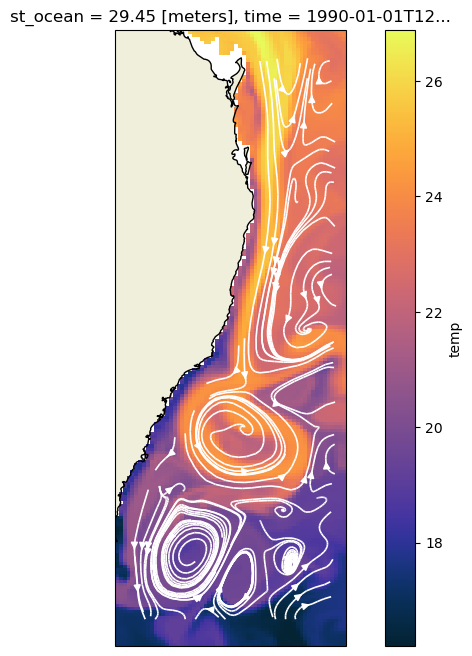

In [30]:
# Plot temperature and streamlines
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
om2_temp.isel(time=0).plot(ax=ax, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.streamplot(x_target, y_target, u_target.isel(time=0), v_target.isel(time=0), density=.8, color='w', transform=ccrs.PlateCarree(), 
              linewidth=1.2, broken_streamlines=False)
ax.coastlines()

In [31]:
colors = ['red', 'white', 'blue']

In [106]:
def plot_eac_temp(i):
    fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    om2_temp.isel(time=i).plot(ax=ax, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    # Plot velocities as streamplot
    ax.streamplot(x_target, y_target, u_target.isel(time=i), v_target.isel(time=i), density=0.6, color='w', transform=ccrs.PlateCarree(),
                    linewidth=1.5, broken_streamlines=False, arrowsize=1, arrowstyle='fancy')
    ax.coastlines()
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [107]:
interact(plot_eac_temp, i=(0, len(om2_temp.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_temp(i)>

So this looks like it all matches up - why didn't the vorticity line up?

In [34]:
# Regrid zeta to shade the vectors
zeta_xgcm_renamed = zeta.rename({'yt_ocean':'lat', 'xt_ocean':'lon'})
x_t = np.linspace(zeta_xgcm_renamed['lon'].min(), zeta_xgcm_renamed['lon'].max(),
                  int(len(zeta_xgcm_renamed['lon'])/res))
y_t = np.linspace(zeta_xgcm_renamed['lat'].min(), zeta_xgcm_renamed['lat'].max(),
                  int(len(zeta_xgcm_renamed['lat'])/res))
X_t, Y_t = np.meshgrid(x_t, y_t)
regridder = xesmf.Regridder(zeta_xgcm_renamed, {'lon':X_t, 'lat':Y_t}, 'bilinear')
zeta_xgcm_regridded = regridder(zeta_xgcm_renamed)
zeta_xgcm_regridded

<xarray.DataArray (time: 10958, y: 190, x: 60)>
array([[[ 2.27330656e-05,  2.34798722e-06,  1.45934257e-06, ...,
         -2.39722908e-06, -1.56490853e-06,  1.11043073e-06],
        [ 2.17439956e-05,  2.28769841e-06,  1.02768513e-06, ...,
         -4.73126924e-08,  1.37748100e-06,  3.08330186e-06],
        [ 1.91106883e-05,  2.04502112e-06,  9.58660848e-07, ...,
         -7.57534735e-07,  1.33621415e-06,  2.97709721e-06],
        ...,
        [            nan,             nan,             nan, ...,
         -4.10760413e-06, -1.67867438e-06,             nan],
        [            nan,             nan,             nan, ...,
         -1.19147330e-06,  2.79763242e-07,             nan],
        [            nan,             nan,             nan, ...,
          5.93282266e-07, -1.84770795e-06,             nan]],

       [[ 1.94853674e-05,  3.29514160e-06,  2.60041816e-06, ...,
         -2.11266547e-06, -1.80327824e-08,  1.02449098e-06],
        [ 2.07796529e-05,  2.34222966e-06,  1.68339443e-06, ...,
          2.45869074e-07,  3.05021058e-06,  4.19792150e-06],
        [ 2.06447694e-05,  2.23099323e-06,  1.54518762e-06, ...,
         -3.72813780e-08,  3.11432950e-06,  3.83449560e-06],
...
         -1.17356030e-05, -1.18105936e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.23406217e-05, -1.22260026e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.31797606e-05, -1.30987273e-05,             nan]],

       [[ 1.43170246e-05,  1.10513802e-05,  1.05946910e-05, ...,
         -1.91571735e-06, -4.32177967e-06, -4.46431977e-06],
        [ 1.83641769e-05,  2.49376990e-05,  2.40364989e-05, ...,
         -1.35176533e-05, -1.57898048e-05, -1.57784689e-05],
        [ 2.20243273e-05,  2.52508107e-05,  2.38878911e-05, ...,
         -1.36941590e-05, -1.39965614e-05, -1.44517744e-05],
        ...,
        [            nan,             nan,             nan, ...,
         -1.29072241e-05, -1.24732360e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.31151528e-05, -1.28310685e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.35814953e-05, -1.36730596e-05,             nan]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
    lat      (y, x) float64 -39.95 -39.95 -39.95 -39.95 ... -24.01 -24.01 -24.01
    lon      (y, x) float64 -209.9 -209.8 -209.7 -209.6 ... -204.2 -204.1 -204.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [35]:
maxvalue = 8e-5
def plot_eac_3plot(i):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    
    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    zeta.isel(time=i).plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    ax2.streamplot(x_target, y_target, u_target.isel(time=i), v_target.isel(time=i), density=0.6, color='k', transform=ccrs.PlateCarree(),
                    linewidth=.5, broken_streamlines=False, arrowsize=1, arrowstyle='fancy')
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    om2_temp.isel(time=i).plot(ax=ax3, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
    ax3.add_feature(cfeature.LAND)
    ax3.coastlines()
    ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [36]:
interact(plot_eac_3plot, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_3plot(i)>

In [37]:
maxvalue = 8e-5
def plot_eac_3plot(i):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    
    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    zeta.isel(time=i).plot.contour(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    om2_temp.isel(time=i).plot(ax=ax3, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
    ax3.streamplot(x_target, y_target, u_target.isel(time=i), v_target.isel(time=i), density=0.6, color='w', transform=ccrs.PlateCarree(),
                    linewidth=.5, broken_streamlines=False, arrowsize=1, arrowstyle='fancy')
    ax3.add_feature(cfeature.LAND)
    ax3.coastlines()
    ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [38]:
interact(plot_eac_3plot, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_3plot(i)>

Below was just to test whether things matched up a bit better between the relative vorticity and the streamlines when using the regridded vorticity rather than the raw vorticity

In [126]:
da = xr.DataArray(zeta_xgcm_regridded.data, coords={'time':zeta.time, 'lat':y_t, 'lon':x_t}, dims=['time', 'lat','lon'])
da

<xarray.DataArray (time: 10958, lat: 190, lon: 60)>
array([[[ 2.27330656e-05,  2.34798722e-06,  1.45934257e-06, ...,
         -2.39722908e-06, -1.56490853e-06,  1.11043073e-06],
        [ 2.17439956e-05,  2.28769841e-06,  1.02768513e-06, ...,
         -4.73126924e-08,  1.37748100e-06,  3.08330186e-06],
        [ 1.91106883e-05,  2.04502112e-06,  9.58660848e-07, ...,
         -7.57534735e-07,  1.33621415e-06,  2.97709721e-06],
        ...,
        [            nan,             nan,             nan, ...,
         -4.10760413e-06, -1.67867438e-06,             nan],
        [            nan,             nan,             nan, ...,
         -1.19147330e-06,  2.79763242e-07,             nan],
        [            nan,             nan,             nan, ...,
          5.93282266e-07, -1.84770795e-06,             nan]],

       [[ 1.94853674e-05,  3.29514160e-06,  2.60041816e-06, ...,
         -2.11266547e-06, -1.80327824e-08,  1.02449098e-06],
        [ 2.07796529e-05,  2.34222966e-06,  1.68339443e-06, ...,
          2.45869074e-07,  3.05021058e-06,  4.19792150e-06],
        [ 2.06447694e-05,  2.23099323e-06,  1.54518762e-06, ...,
         -3.72813780e-08,  3.11432950e-06,  3.83449560e-06],
...
         -1.17356030e-05, -1.18105936e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.23406217e-05, -1.22260026e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.31797606e-05, -1.30987273e-05,             nan]],

       [[ 1.43170246e-05,  1.10513802e-05,  1.05946910e-05, ...,
         -1.91571735e-06, -4.32177967e-06, -4.46431977e-06],
        [ 1.83641769e-05,  2.49376990e-05,  2.40364989e-05, ...,
         -1.35176533e-05, -1.57898048e-05, -1.57784689e-05],
        [ 2.20243273e-05,  2.52508107e-05,  2.38878911e-05, ...,
         -1.36941590e-05, -1.39965614e-05, -1.44517744e-05],
        ...,
        [            nan,             nan,             nan, ...,
         -1.29072241e-05, -1.24732360e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.31151528e-05, -1.28310685e-05,             nan],
        [            nan,             nan,             nan, ...,
         -1.35814953e-05, -1.36730596e-05,             nan]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
  * lat      (lat) float64 -39.95 -39.87 -39.78 -39.7 ... -24.18 -24.1 -24.01
  * lon      (lon) float64 -209.9 -209.8 -209.7 -209.6 ... -204.2 -204.1 -204.0

In [140]:
def compare_zeta(i):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    da.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree())
    ax1.streamplot(x_target, y_target, u_target.isel(time=i), v_target.isel(time=0), transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.set_title('Zeta Regridded')
    zeta.isel(time=i).plot(ax=ax2, transform=ccrs.PlateCarree())
    ax2.streamplot(x_target, y_target, u_target.isel(time=i), v_target.isel(time=0), transform=ccrs.PlateCarree())
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.set_title('Zeta Raw')

In [141]:
interact(compare_zeta, i=(0, len(zeta.time),1))

interactive(children=(IntSlider(value=5479, description='i', max=10958), Output()), _dom_classes=('widget-inte…

<function __main__.compare_zeta(i)>

Turns out overall that things don't really change between the two above. Just so happens that sometimes things are a bit offset, particularly near the boundaries and in the weaker structures. 

Could we possibly add some MHW information to the above plot?

Plot when given cells are under MHW conditions? For that, we'd need to run a MHW analysis over a depth of say 30m (Below the Ekman Layer).

That could be quite cool actually.

**After discussion with Chris:**
So there's two different focal points here - (1) The dynamical systems work around eddy shedding, and (2) the MHW work around coastal temperature extremes. They most certainly overlap however the future analysis that's needed for these two directions is quite different. 

* For the eddy shedding - I'm interested in whether there's any periodicity in the anticylonic eddy variability in the EAC extension. For that - as Chris mentioned, the EKE might not be the most suitable metric as it removes the polarity of the eddies, whereas perhaps taking the positive potential vorticity might be more suitable? 

In [241]:
# separation box
sep_idx = {'W':-208.5, 'E':-206.5, 'S':-36.5, 'N': -34}
zeta_sep = zeta.sel(xt_ocean=slice(sep_idx['W'], sep_idx['E']), yt_ocean=slice(sep_idx['S'], sep_idx['N'])).mean(['xt_ocean','yt_ocean'])

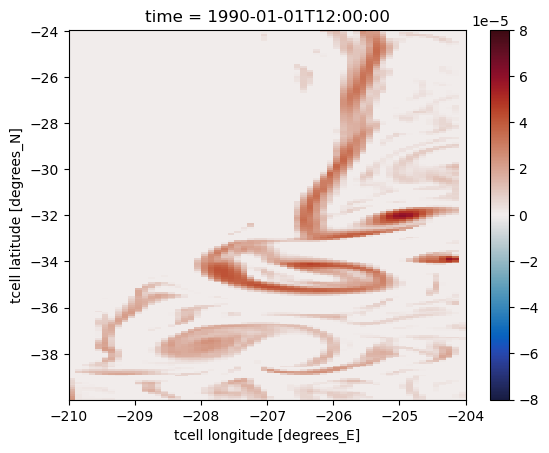

In [269]:
zeta_pos = zeta.where(zeta > 0, 0)
zeta_pos.isel(time=0).plot(cmap=cm.cm.balance, vmin=-maxvalue, vmax=maxvalue)

In [272]:
da = zeta_pos
ts = zeta_pos.sel(xt_ocean=slice(sep_idx['W'], sep_idx['E']), yt_ocean=slice(sep_idx['S'], sep_idx['N'])).mean(['xt_ocean','yt_ocean'])
def plot_zeta_box(i):
    fig = plt.figure(figsize=(10,4))
    gs = fig.add_gridspec(2,5)
    ax1 = fig.add_subplot(gs[:,0], projection=ccrs.PlateCarree())
    da.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=-maxvalue, vmax=maxvalue)
    sep_box = patches.Rectangle((sep_idx['W'], sep_idx['S']), (sep_idx['E']-sep_idx['W']), (sep_idx['N']-sep_idx['S']),
                                fill=None, color='r', transform=ccrs.PlateCarree())
    ax1.add_patch(sep_box)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    
    # fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios':[1,2]})
    # ax1 = plt.subplot(projection=ccrs.PlateCarree())

    xmin = np.max([0, i-500])
    xmax = np.min([i+500, len(zeta.time)])
    ax2 = fig.add_subplot(gs[:,2:])
    ax2.plot(ts)
    ax2.set_xlim(xmin, xmax)
    ax2.scatter(i, ts[i], color='r', zorder=3)
    ax2.set_xlabel('Days since 1990-01-01')

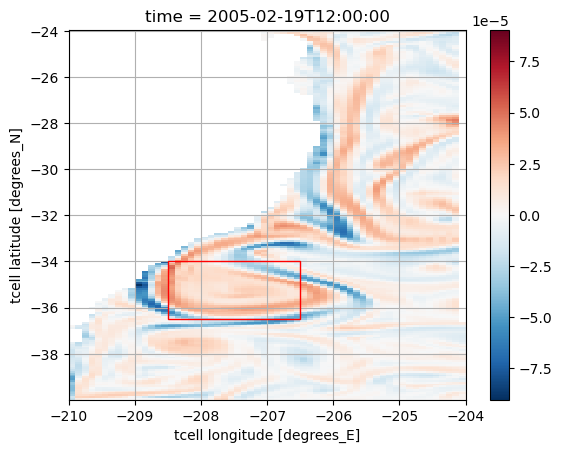

In [273]:
fig, ax = plt.subplots()
zeta.isel(time=5529).plot(ax=ax)
sep_box = patches.Rectangle((sep_idx['W'], sep_idx['S']), (sep_idx['E']-sep_idx['W']), (sep_idx['N']-sep_idx['S']),
                            fill=None, color='r', zorder=3)#, transform=ccrs.PlateCarree())
ax.add_patch(sep_box)
ax.grid()

In [274]:
interact(plot_zeta_box, i=(0, len(zeta.time),1))

interactive(children=(IntSlider(value=5479, description='i', max=10958), Output()), _dom_classes=('widget-inte…

<function __main__.plot_zeta_box(i)>

In [292]:
from scipy.signal import find_peaks

In [300]:
peak_indices, _ = find_peaks(ts, height=0.8E-05, distance=80)
peak_indices

array([   15,   161,   308,   606,   855,  1099,  1330,  1506,  1782,
        1893,  2178,  2614,  2884,  2999,  3212,  3445,  3647,  3783,
        3888,  4003,  4224,  4457,  4690,  4796,  4944,  5087,  5241,
        5525,  5607,  5816,  6082,  6222,  6444,  6612,  6922,  7019,
        7112,  7320,  7402,  7498,  7655,  7917,  8112,  8194,  8359,
        8457,  8672,  8807,  9066,  9209,  9323,  9450,  9575,  9665,
        9754,  9886,  9987, 10108, 10289, 10474, 10584, 10665, 10786,
       10948])

In [302]:
# Find the difference between the peaks...
peak_diff = np.diff(peak_indices)
peak_diff.mean()

173.53968253968253

In [303]:
import seaborn as sns

Text(0, 0.5, 'Density')

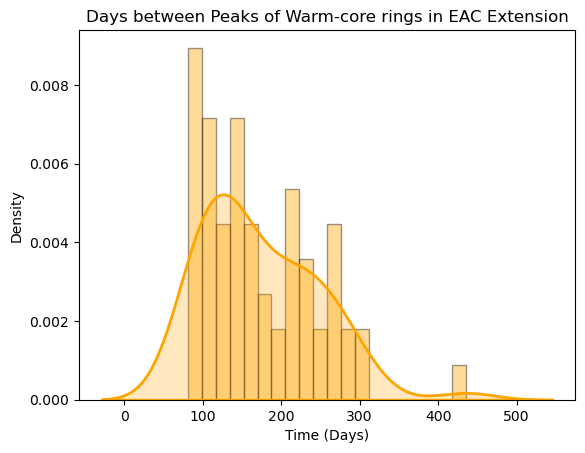

In [317]:
sns.distplot(peak_diff, hist=True, kde=True,
             bins=20,
             color='orange',
             hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':2, 'bw':0.5, 'shade':True})
plt.title('Days between Peaks of Warm-core rings in EAC Extension')
plt.xlabel('Time (Days)')
plt.ylabel('Density')


#### Fourier Analysis with `scipy`

In [275]:
from scipy.fft import fft, fftfreq
import pandas as pd

In [247]:
zeta_sep = xr.where(zeta_sep.isnull(), 0, zeta_sep)

In [248]:
import scipy.signal as signal

In [276]:
Ts = 365.25
Fs = 1/Ts
T = 50
Wp = Ts/T
sos = signal.cheby1(4,5,Wp,fs=Ts,output='sos')

In [277]:
ts

<xarray.DataArray (time: 10958)>
array([7.9173087e-06, 8.5560714e-06, 8.8590095e-06, ..., 8.2404522e-06,
       8.3091309e-06, 8.4161693e-06], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00

In [278]:
filtered = signal.sosfilt(sos, ts.data, axis=0)
filtered

array([1.02313766e-11, 9.22112325e-11, 4.20152365e-10, ...,
       3.20464725e-06, 3.28242127e-06, 3.36219084e-06])

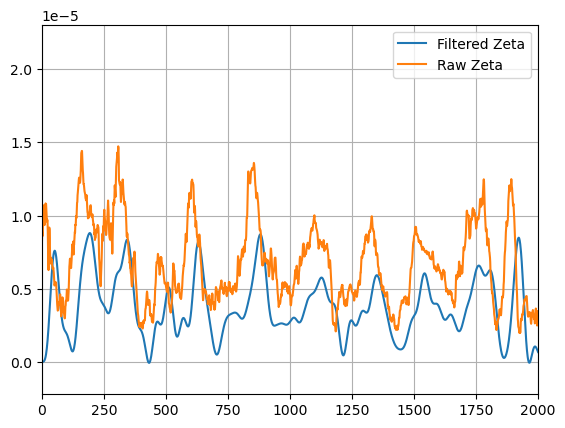

In [280]:
plt.plot(filtered, label='Filtered Zeta')
plt.plot(ts, label='Raw Zeta')
plt.xlim(0, 2000)
plt.legend()
plt.grid()

In [281]:
N = len(zeta_sep.time)
# sample spacing 
T = 1 # days
x = np.linspace(0, N*T, endpoint=False)
yf = fft(filtered)
xf = fftfreq(N, T)[:N//2]

Text(0.5, 1.0, 'FFT on entire time-series')

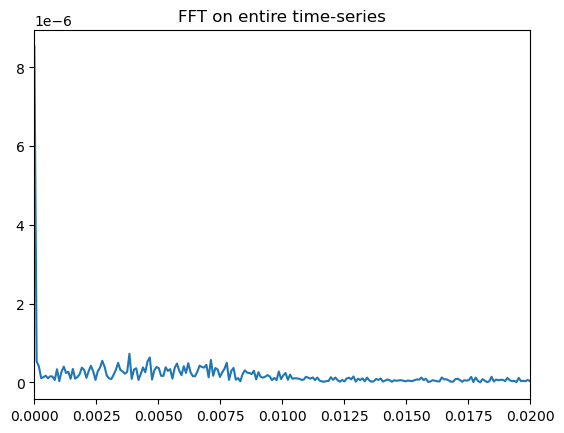

In [282]:
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlim(0,0.02)
plt.title('FFT on entire time-series')

So the above is for the whole time series - but what about if we just look at year-by-year?

In [283]:
filtered_da = xr.DataArray(filtered, 
                           coords={'time':zeta_sep.time.values},
                           dims=['time'])
filtered_da

<xarray.DataArray (time: 10958)>
array([1.02313766e-11, 9.22112325e-11, 4.20152365e-10, ...,
       3.20464725e-06, 3.28242127e-06, 3.36219084e-06])
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00

In [284]:
years = zeta_sep.groupby(zeta_sep['time.year']).groups.keys()
years


dict_keys([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [285]:
def fft_map(year_block):
    N = len(year_block.time)
    x = np.linspace(0, N, endpoint=False)
    yf = fft(year_block.data)
    xf = fftfreq(N,T)[:N//2]
    return N, xf, yf

In [287]:
spectral_analysis_ls = []
step = 700
for year in range(1,15):
    slice_start = (year-1)*step
    slice_end = (year+1)*step
    year_str = f'{year}'
    zeta_sep_block = filtered_da.isel(time=slice(slice_start, slice_end))
    N, xf, yf = fft_map(zeta_sep_block)
    spectral_analysis_ls.append([N, xf, yf])
    # print(f'finished year {year}')

In [288]:
df = pd.DataFrame(spectral_analysis_ls)
df

,0,1,2
0,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0054607669919427265-0j), (0.00012917821011..."
1,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.004948976089911572-0j), (3.886354525409829..."
2,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.004391356537576909-0j), (-0.00011589269907..."
3,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.004950593678896241-0j), (-0.00031584704184..."
4,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.005916040879032081-0j), (0.000382597437316..."
5,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.006307178704868648-0j), (0.000148098527080..."
6,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0064295330846463284-0j), (0.00015865622738..."
7,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.006301991150393694-0j), (0.000198107783791..."
8,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.005649715446087875-0j), (-0.00041008431246..."
9,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.006240574144264088-0j), (-4.72251480242513..."


Now take the average of all the frequency spectra...

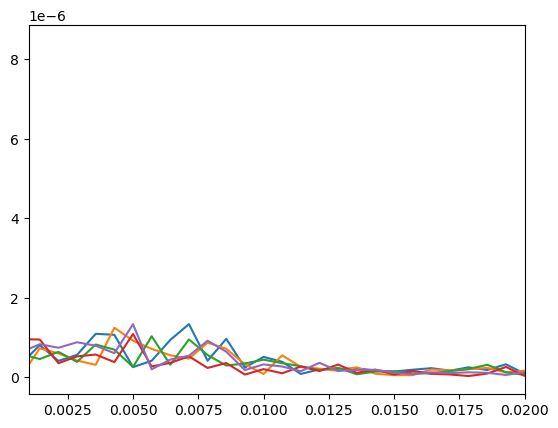

In [290]:
for year in range(5):
    yf = df[2][year]
    xf = df[1][year]
    N = df[0][year]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.xlim(0.001,0.02)
    # plt.xlim(0, 200)


In [291]:
1/0.0075

133.33333333333334

In [67]:
def fft_map(year_block):
    N = len(year_block.time)
    x = np.linspace(0, N, endpoint=False)
    yf = fft(year_block.data)
    xf = fftfreq(N,T)[:N//2]
    return N, xf, yf

In [125]:
spectral_analysis_ls = []
step = 700
for year in range(1,15):
    slice_start = (year-1)*step
    slice_end = (year+1)*step
    year_str = f'{year}'
    zeta_sep_block = zeta_sep.isel(time=slice(slice_start, slice_end))
    N, xf, yf = fft_map(zeta_sep_block)
    spectral_analysis_ls.append([N, xf, yf])
    # print(f'finished year {year}')

In [126]:
df = pd.DataFrame(spectral_analysis_ls)
df

,0,1,2
0,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.002019464-0j), (-0.0004655351-0.0004094316..."
1,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0020082134-0j), (0.0009924266+0.0004129545..."
2,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.003121387-0j), (0.00048634748+0.0002655997..."
3,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0040734783-0j), (-0.00020840787+0.00047477..."
4,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0047999546-0j), (-0.00045460733+0.00024179..."
5,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0039069783-0j), (0.00014823134-0.000746242..."
6,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0028101802-0j), (-0.0007427658+0.000220723..."
7,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0029345541-0j), (0.00045035966-6.843081e-0..."
8,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0028787847-0j), (5.4282427e-06-0.000498048..."
9,1400,"[0.0, 0.0007142857142857143, 0.001428571428571...","[(0.0032189337-0j), (0.00013571861+0.000775386..."


Now take the average of all the frequency spectra...

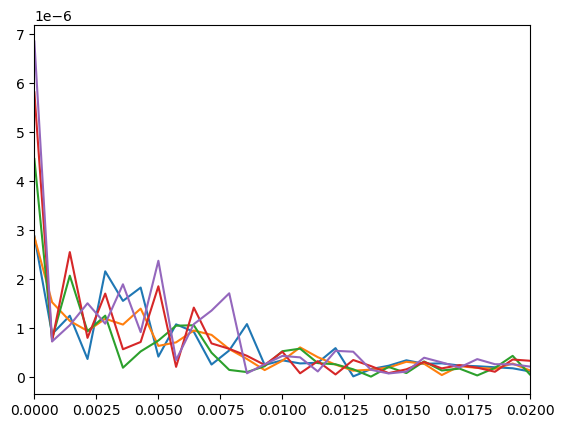

In [127]:
for year in range(5):
    yf = df[2][year]
    xf = df[1][year]
    N = df[0][year]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.xlim(0,0.02)
    # plt.xlim(0, 200)


Okay, so I was hoping that we might find a stronger periodicity in the frequency spectra for hte 

In [124]:
1/.0075

133.33333333333334

In [93]:
yf_total = df[2]
xf_total = df[1]
N = df[0]
yf_total[:10]

0    [(0.0003710064232529723-0j), (-2.1244899608998...
1    [(0.000328418073329072-0j), (-6.94286591833335...
2    [(0.0004667733291463324-0j), (0.00050622389403...
3    [(5.5820740331471255e-05-0j), (0.0001288510941...
4    [(0.00018159450934131043-0j), (-5.839813838957...
5    [(0.0005773913477687821-0j), (-6.8206513242267...
6    [(0.00013464331686415356-0j), (-7.378837164370...
7    [(0.0008516712344169373-0j), (-0.0003588401246...
8    [(0.00040586169632747857-0j), (8.7943734690479...
9    [(0.0009778844913220374-0j), (0.00032018949537...
Name: 2, dtype: object

In [95]:
yf = yf_total.mean(axis=0)
xf = xf_total.mean(axis=0)

(0.001, 0.1)

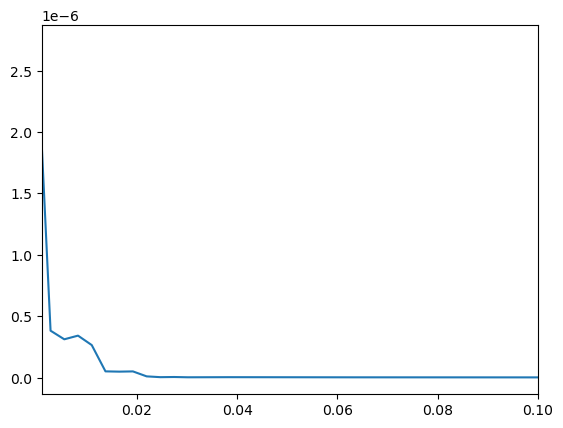

In [100]:
plt.plot(xf, 2.0/365 * np.abs(yf[:365//2]))
plt.xlim(0.001, 0.1)

In [236]:
for i in range(5):
    N, xf, yf = df[i]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    # plt.xlabel('days')
    plt.xlim(0, 0.02)

ValueError: too many values to unpack (expected 3)

In [141]:
nan_mask = zeta_sep.isnull()
nan_indices = np.where(nan_mask)
print('Indices of NaN values: ', nan_indices)

Indices of NaN values:  (array([2099]),)


In [142]:
zeta_sep[2099].values = 0

In [143]:
zeta_sep[2099].values

array(nan, dtype=float32)

In [144]:
zeta_sep = xr.where(zeta_sep.isnull(), 0, zeta_sep)

In [146]:
N = len(zeta_sep.time)
# sample spacing 
T = 1 # days
x = np.linspace(0, N*T, endpoint=False)
yf = fft(zeta_sep.data)
xf = fftfreq(N, T)[:N//2]

In [129]:
np.abs(yf)

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [182]:
def fft_map(year_block):
    N = len(year_block.time)
    x = np.linspace(0, N, endpoint=False)
    yf = fft(year_block.data)
    xf = fftfreq(N,T)[:N//2]
    return N, xf, yf

In [ ]:
bins = 360
ds = zeta_sep.groupby_bins(

In [202]:
spectral_analysis_ls = []
for year in zeta_sep_yearly.groups.keys():
    year_str = f'{year}'
    zeta_sep_block = zeta_sep.sel(time=year_str)
    N, xf, yf = fft_map(zeta_sep_block)
    spectral_analysis_ls.append([N, xf, yf])
    print(f'finished year {year}')

finished year 1990
finished year 1991
finished year 1992
finished year 1993
finished year 1994
finished year 1995
finished year 1996
finished year 1997
finished year 1998
finished year 1999
finished year 2000
finished year 2001
finished year 2002
finished year 2003
finished year 2004
finished year 2005
finished year 2006
finished year 2007
finished year 2008
finished year 2009
finished year 2010
finished year 2011
finished year 2012
finished year 2013
finished year 2014
finished year 2015
finished year 2016
finished year 2017
finished year 2018
finished year 2019


In [207]:
df = pd.DataFrame(spectral_analysis_ls)
df

,0,1,2
0,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.00064754416-0j), (3.3985103e-05-0.00030995..."
1,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.0007196941-0j), (0.00013546638-0.000338374..."
2,366,"[0.0, 0.00273224043715847, 0.00546448087431694...","[(0.0006869215-0j), (0.0007516225-0.0002178182..."
3,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.00013877987-0j), (0.00022467392+0.00011871..."
4,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.00029932076-0j), (-0.000159753+9.5136e-05j..."
5,366,"[0.0, 0.00273224043715847, 0.00546448087431694...","[(0.0010388764-0j), (-0.000106781285+4.326501e..."
6,366,"[0.0, 0.00273224043715847, 0.00546448087431694...","[(0.00029143383-0j), (-1.1592744e-05-0.0001873..."
7,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.0015111673-0j), (-0.00048958685-0.00038609..."
8,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.000847594-0j), (0.0002780523+3.579523e-05j..."
9,365,"[0.0, 0.0027397260273972603, 0.005479452054794...","[(0.0015142339-0j), (0.00043863844-0.000408822..."


In [238]:
df[1]

0     [0.0, 0.0027397260273972603, 0.005479452054794...
1     [0.0, 0.0027397260273972603, 0.005479452054794...
2     [0.0, 0.00273224043715847, 0.00546448087431694...
3     [0.0, 0.0027397260273972603, 0.005479452054794...
4     [0.0, 0.0027397260273972603, 0.005479452054794...
5     [0.0, 0.00273224043715847, 0.00546448087431694...
6     [0.0, 0.00273224043715847, 0.00546448087431694...
7     [0.0, 0.0027397260273972603, 0.005479452054794...
8     [0.0, 0.0027397260273972603, 0.005479452054794...
9     [0.0, 0.0027397260273972603, 0.005479452054794...
10    [0.0, 0.00273224043715847, 0.00546448087431694...
11    [0.0, 0.0027397260273972603, 0.005479452054794...
12    [0.0, 0.0027397260273972603, 0.005479452054794...
13    [0.0, 0.0027397260273972603, 0.005479452054794...
14    [0.0, 0.00273224043715847, 0.00546448087431694...
15    [0.0, 0.0027397260273972603, 0.005479452054794...
16    [0.0, 0.0027397260273972603, 0.005479452054794...
17    [0.0, 0.0027397260273972603, 0.00547945205

In [236]:
for i in range(5):
    N, xf, yf = df[i]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    # plt.xlabel('days')
    plt.xlim(0, 0.02)

ValueError: too many values to unpack (expected 3)

In [211]:
yf_mean = df[2].mean()
yf_mean

TypeError: operands could not be broadcast together with shapes (365,) (366,) 

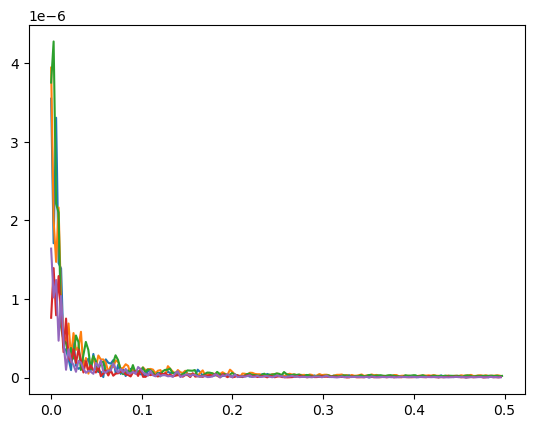

In [193]:
for i in range(5):
    N, xf, yf = spectral_analysis_ls[i]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    N_ls.append(N)
    # plt.xlabel('days')
    # plt.xlim(0, 0.02)

In [189]:
1/0.01

100.0

In [ ]:
plt.plot(spectral_analysis_ls[0]

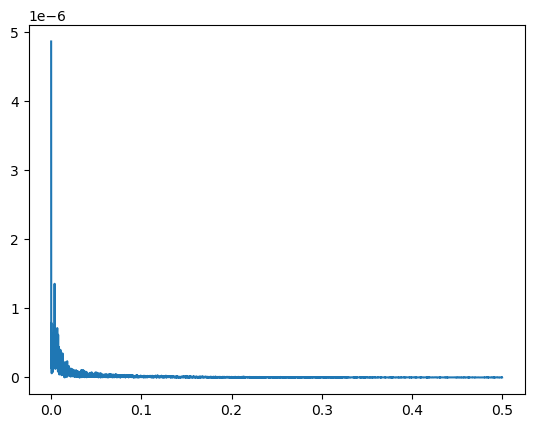

In [147]:
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

In [120]:
x = np.arange(len(zeta_sep.time))
y = zeta_sep.data
da = xr.DataArray(y, dims=('x',), coords={'x':x})

In [121]:
%%time
da_dft = xrft.dft(da, true_phase=True, true_amplitude=True) # Fourier transform with consideration of phase
da_fft = xrft.fft(da) # Fourier transform w/ numpy.fft-like behaviour
da_npft = npft.fft(da)

CPU times: user 37.2 ms, sys: 1.77 ms, total: 38.9 ms
Wall time: 34.3 ms


In [109]:
k = da_dft.freq_x # Wavenumber axis

In [ ]:
fig, (

In [82]:
%%time 
spectral_analysis_ls = []
i=0
zeta_sep_yearly = zeta_sep.groupby(zeta_sep['time.year'])
for year in zeta_sep_yearly:
    i+=1
    # Apply fourier transform to each yearly group
    fourier = np.fft.fft(year)
    # Compute the power spectral density
    psd = np.abs(fourier_transform)**2
    # Extract frequencies
    freqs = np.fft.fftfreq(len(psd), d=1)
    spectral_analysis_ls.append([fourier, psd, freqs])
    print(f'finished year {i}')


AttributeError: 'tuple' object has no attribute 'values'

(-220.0, -194.0)

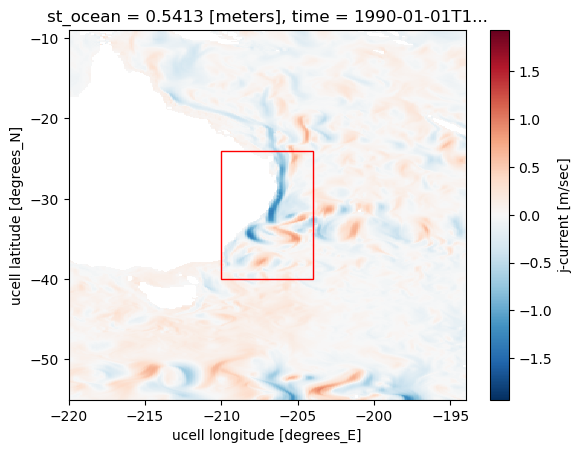

In [32]:
# Select u,v and subset to same domain as 'eac_eddy' 
eddy_idx = {'W':-210, 'E':-204, 'S':-40, 'N':-24}
# Quick plot to show the rough location...
fig, ax = plt.subplots()
om2_iaf['v'].isel(st_ocean=0, time=0).plot(ax=ax)
eddy_box = patches.Rectangle((eddy_idx['W'], eddy_idx['S']), (eddy_idx['E']-eddy_idx['W']),
                             (eddy_idx['N']-eddy_idx['S']), color='r', fill=None)
ax.add_patch(eddy_box)
ax.set_ylim(eddy_idx['S']-15, eddy_idx['N']+15)
ax.set_xlim(eddy_idx['W']-10, eddy_idx['E']+10)

In [44]:
sep_idx

{'W': -207, 'E': -204.8, 'S': 34, 'N': 32.5}

In [45]:
zeta.xt_ocean

<xarray.DataArray 'xt_ocean' (xt_ocean: 60)>
array([-209.95, -209.85, -209.75, -209.65, -209.55, -209.45, -209.35, -209.25,
       -209.15, -209.05, -208.95, -208.85, -208.75, -208.65, -208.55, -208.45,
       -208.35, -208.25, -208.15, -208.05, -207.95, -207.85, -207.75, -207.65,
       -207.55, -207.45, -207.35, -207.25, -207.15, -207.05, -206.95, -206.85,
       -206.75, -206.65, -206.55, -206.45, -206.35, -206.25, -206.15, -206.05,
       -205.95, -205.85, -205.75, -205.65, -205.55, -205.45, -205.35, -205.25,
       -205.15, -205.05, -204.95, -204.85, -204.75, -204.65, -204.55, -204.45,
       -204.35, -204.25, -204.15, -204.05])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -204.2 -204.1 -204.0
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X
    axis:            X

In [47]:
def plot_zeta_mean(i):
    fig, ax = plt.subplots()
    zeta_sep.plot(ax=ax)
    zeta_mean = 
    ax.set_title

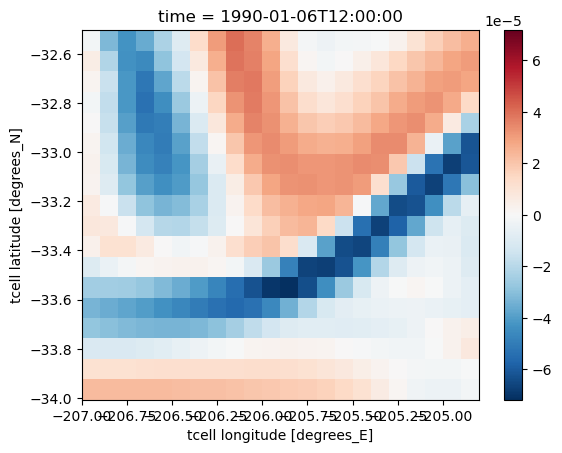

In [46]:
# separation box
sep_idx = {'W':153-360, 'E':155.2-360, 'S':-34, 'N': -32.5}
zeta_sep = zeta.sel(xt_ocean=slice(sep_idx['W'], sep_idx['E']), yt_ocean=slice(sep_idx['S'], sep_idx['N']))
zeta_sep.isel(time=5).plot()

In [43]:
zeta.xt_ocean

<xarray.DataArray 'xt_ocean' (xt_ocean: 60)>
array([-209.95, -209.85, -209.75, -209.65, -209.55, -209.45, -209.35, -209.25,
       -209.15, -209.05, -208.95, -208.85, -208.75, -208.65, -208.55, -208.45,
       -208.35, -208.25, -208.15, -208.05, -207.95, -207.85, -207.75, -207.65,
       -207.55, -207.45, -207.35, -207.25, -207.15, -207.05, -206.95, -206.85,
       -206.75, -206.65, -206.55, -206.45, -206.35, -206.25, -206.15, -206.05,
       -205.95, -205.85, -205.75, -205.65, -205.55, -205.45, -205.35, -205.25,
       -205.15, -205.05, -204.95, -204.85, -204.75, -204.65, -204.55, -204.45,
       -204.35, -204.25, -204.15, -204.05])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -204.2 -204.1 -204.0
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X
    axis:            X

### 2. MOM6 EKE Calcs
Here, we have to do a bit more prep to regrid one velocity onto the other velocities grid...

#### 2.1 STHPAC-01
Note that the below code will change as we are now subsetting on Setonix and moving over the smaller amount of data so we don't need to do any spatial subsetting here.

In [ ]:
### for STHPAC
u_files = get_mom6_files(years='all', input_vars=['u'])
v_files = get_mom6_files(years='all', input_vars=['v'])
u = xr.open_mfdataset(u_files)['uo']
v = xr.open_mfdataset(v_files)['vo']
vel = xr.merge([u,v])
vel

**Using xgcm**

In [ ]:
# Check for symmetry in the native c-grid
corner = [np.round(vel.xq.min().values,2), np.round(vel.yq.min().values,2)]
centre = [np.round(vel.xh.min().values,2), np.round(vel.yh.min().values,2)]

if corner[0] < centre[0]:
    print(f'Native C-grid is symmetric - most south-western point is a corner.\nMight need to drop this corner point?')
else:
    print(f'Native C-grid is antisymmetric - most south-western point is a centre.')

In [ ]:
# If grids are symmetric, drop corner point


In [ ]:
def make_grid_antisymmetric(da):
    '''
    Checks if native MOM6 grid is symmetric or antisymmetric. 
    XGCM requires grid to be antisymmetric - i.e., left-most col and
    bottom-row to be a centre point
    '''
    corner = [np.round(da.xq.min().values,2), np.round(da.yq.min().values,2)]
    centre = [np.round(da.xh.min().values,2), np.round(da.yh.min().values,2)]
    # Check if grid is symmetric
    if corner[0] < centre[0]:
        print(f'Native C-grid is symmetric - most south-western point is a corner.\nDropping left-col/bottom-row')
        da = da.isel(xq=slice(1,len(da.xq)))
        da = da.isel(yq=slice(1,len(da.yq)))
    else:
        print(f'Native C-grid is antisymmetric - most south-western point is a centre.')
    return da

In [ ]:
vel = make_grid_antisymmetric(vel)